# 1. LOAD LIBRARY

In [35]:
# Xử lý thời gian và dữ liệu
from datetime import datetime
import pandas as pd
import numpy as np

# Thống kê và phân tích
import random
from scipy.stats import (chi2, chi2_contingency, zscore, ttest_1samp, ttest_ind, levene, kstest, mannwhitneyu, ttest_rel, norm, rankdata, kruskal, pearsonr, spearmanr)
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Làm việc với Google Sheets
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
from google.auth import default
from google.colab import auth

# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1000)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. READ DATA

In [36]:
# File path to your file
file_path = "/content/drive/My Drive/Colab Notebooks/Marketing Mix Modeling/Data/mediamix_sales.csv"

# Read the SPSS file
df = pd.read_csv(file_path)

print(df.columns)

Index(['Time', 'tv_sponsorships', 'tv_cricket', 'tv_RON', 'radio', 'NPP', 'Magazines', 'OOH', 'Social', 'Programmatic', 'Display_Rest', 'Search', 'Native', 'sales'], dtype='object')


In [37]:
df = df.rename(columns={'Time': 'time'})
df['time'] = pd.to_datetime(df['time']) #format='%Y'
df = df.rename(columns={'tv_RON': 'tv_ron'})
df = df.rename(columns={'NPP': 'npp'})
df = df.rename(columns={'Magazines': 'magazines'})
df = df.rename(columns={'OOH': 'ooh'})
df = df.rename(columns={'Social': 'social'})
df = df.rename(columns={'Programmatic': 'programmatic'})
df = df.rename(columns={'Display_Rest': 'display_rest'})
df = df.rename(columns={'Search': 'search'})
df = df.rename(columns={'Native': 'native'})

df = df[['time','tv_sponsorships', 'tv_cricket', 'tv_ron', 'radio', 'npp', 'magazines', 'ooh', 'social', 'programmatic', 'display_rest', 'search', 'native','sales']]

<ipython-input-37-50092eaf62e5>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time']) #format='%Y'


# 3. DESCRIPTIVE DATA

In [38]:
df.head()

,time,tv_sponsorships,tv_cricket,tv_ron,radio,npp,magazines,ooh,social,programmatic,display_rest,search,native,sales
0,2001-01-01,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,26.802048,5,22100
1,2001-01-02,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400
2,2001-01-03,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300
3,2001-01-04,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500
4,2001-01-05,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             200 non-null    datetime64[ns]
 1   tv_sponsorships  200 non-null    float64       
 2   tv_cricket       200 non-null    float64       
 3   tv_ron           200 non-null    float64       
 4   radio            200 non-null    float64       
 5   npp              200 non-null    float64       
 6   magazines        200 non-null    float64       
 7   ooh              200 non-null    int64         
 8   social           200 non-null    float64       
 9   programmatic     200 non-null    int64         
 10  display_rest     200 non-null    float64       
 11  search           200 non-null    float64       
 12  native           200 non-null    int64         
 13  sales            200 non-null    int64         
dtypes: datetime64[ns](1), float64(9), int64(4)

In [40]:
df.describe()

,time,tv_sponsorships,tv_cricket,tv_ron,radio,npp,magazines,ooh,social,programmatic,display_rest,search,native,sales
count,200,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2008-11-08 14:52:48,59.512390,41.657365,51.143055,23.264000,24.372700,4.543300,29.350000,21.925009,17.650000,18.090883,15.664170,5.060000,14022.500000
min,2001-01-01 00:00:00,0.700000,1.000000,0.000000,0.000000,0.270000,0.030000,15.000000,0.245000,5.000000,0.196000,0.156800,5.000000,1600.000000
25%,2005-01-02 18:00:00,14.017500,1.750000,14.935000,9.975000,10.000000,1.015000,18.750000,9.259250,20.000000,3.986500,5.925920,5.000000,10375.000000
50%,2009-01-04 12:00:00,44.705000,19.022000,31.330000,22.900000,18.800000,3.420000,30.000000,17.329375,20.000000,15.584800,14.106848,5.000000,12900.000000
75%,2013-01-06 06:00:00,92.777500,68.286500,67.262500,36.525000,36.080000,6.185000,40.000000,33.302500,20.000000,29.134560,23.966880,5.000000,17400.000000
max,2017-01-08 00:00:00,224.560000,207.480000,253.260000,49.600000,91.200000,22.800000,40.000000,78.596000,20.000000,62.876800,50.301440,9.000000,27000.000000
std,NaN,50.672105,49.165205,52.431041,14.846809,18.054915,4.187503,10.103858,17.342664,4.508785,14.692380,11.355416,0.408945,5217.456566


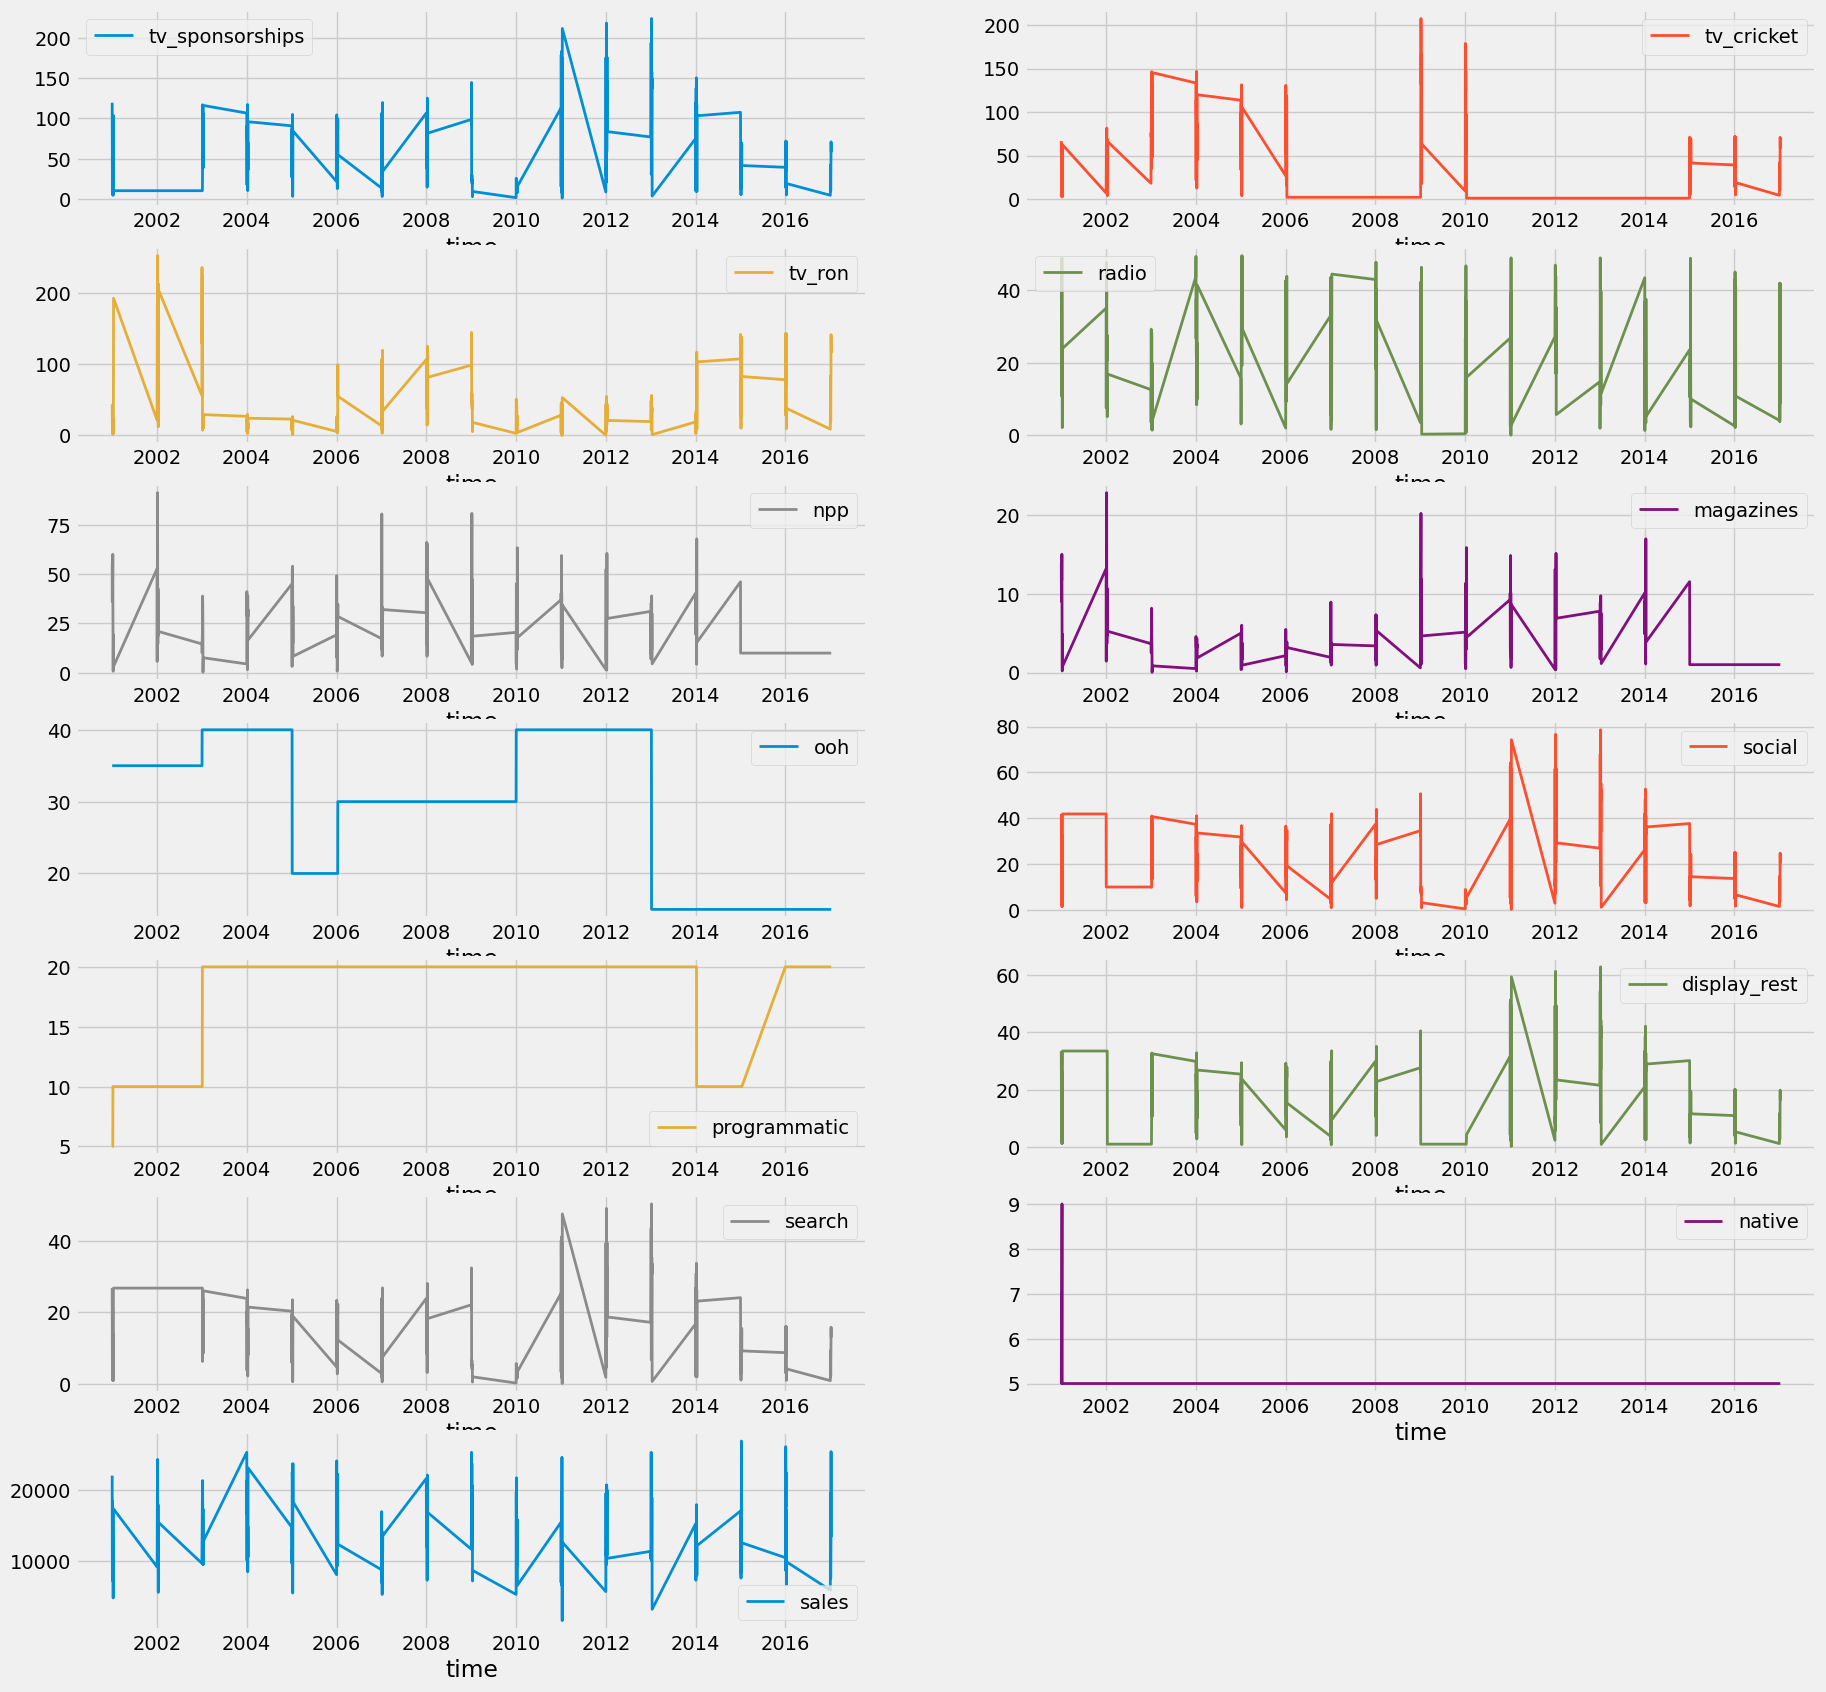

In [41]:
plt.style.use('fivethirtyeight')

df2 = df.copy('Deep')
df2 = df2.set_index('time')

# Facet plots
df2.plot(subplots=True,
        linewidth=2,
        layout=(7, 2), # 4 rows, 1 column
        figsize=(20, 20), # width 20
        sharex=False,
        sharey=False)
plt.show()

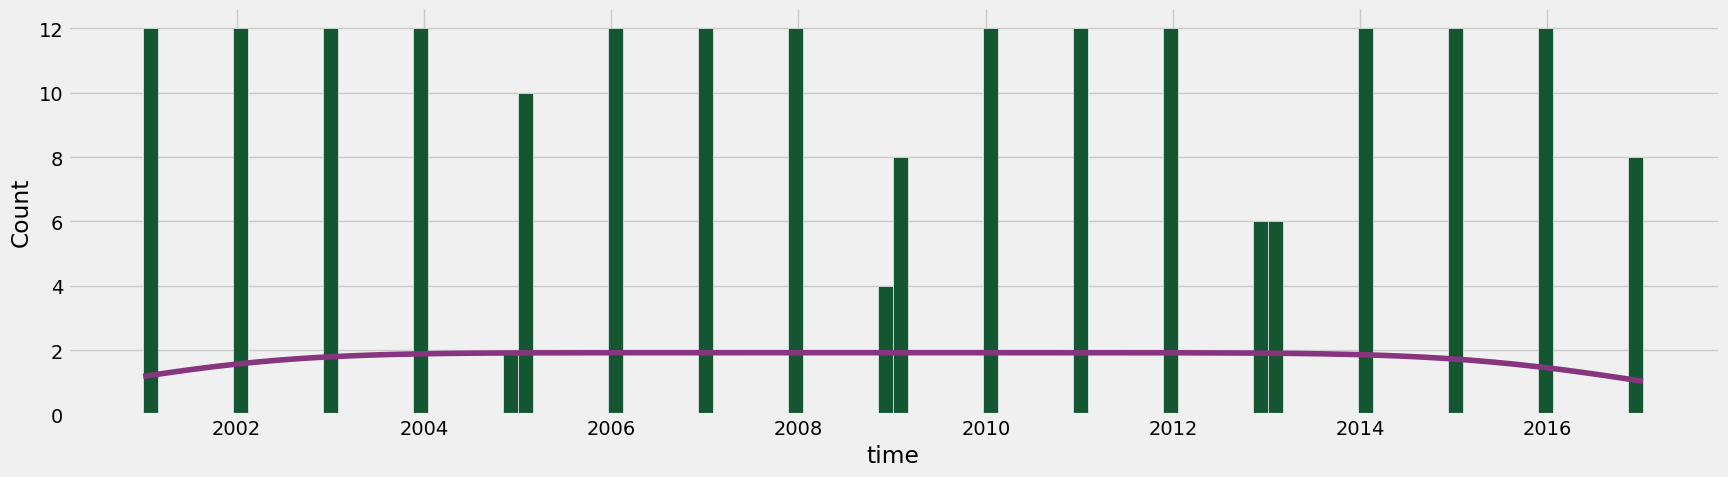

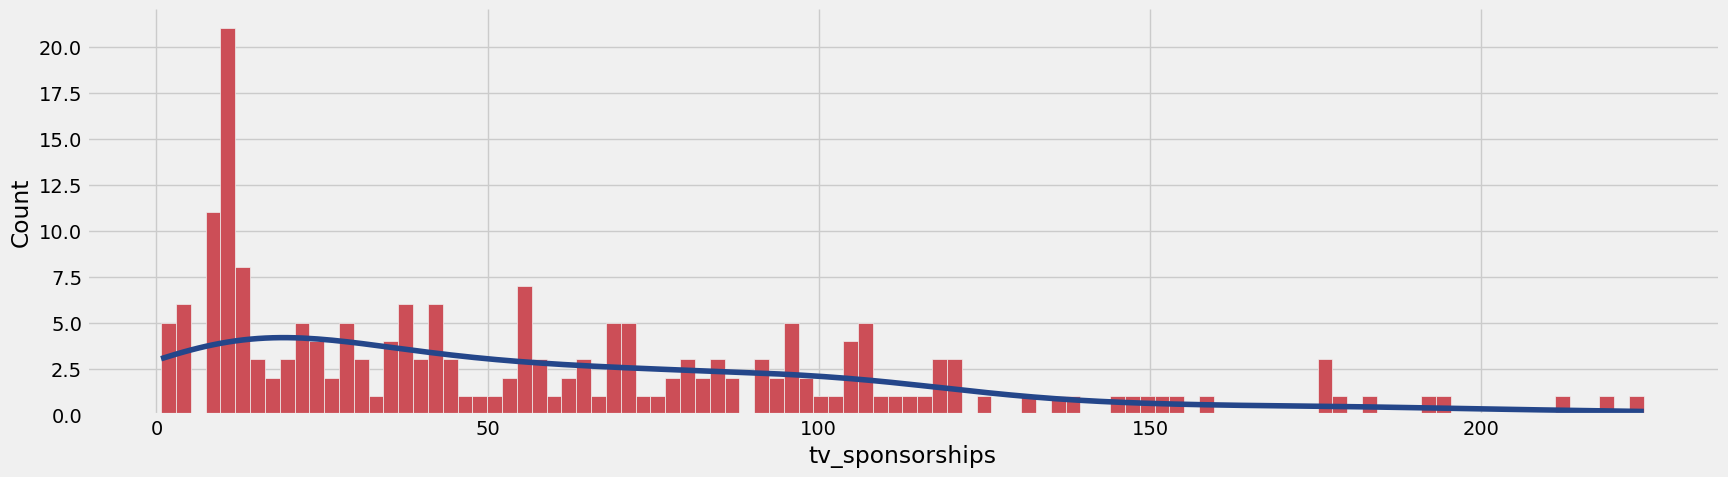

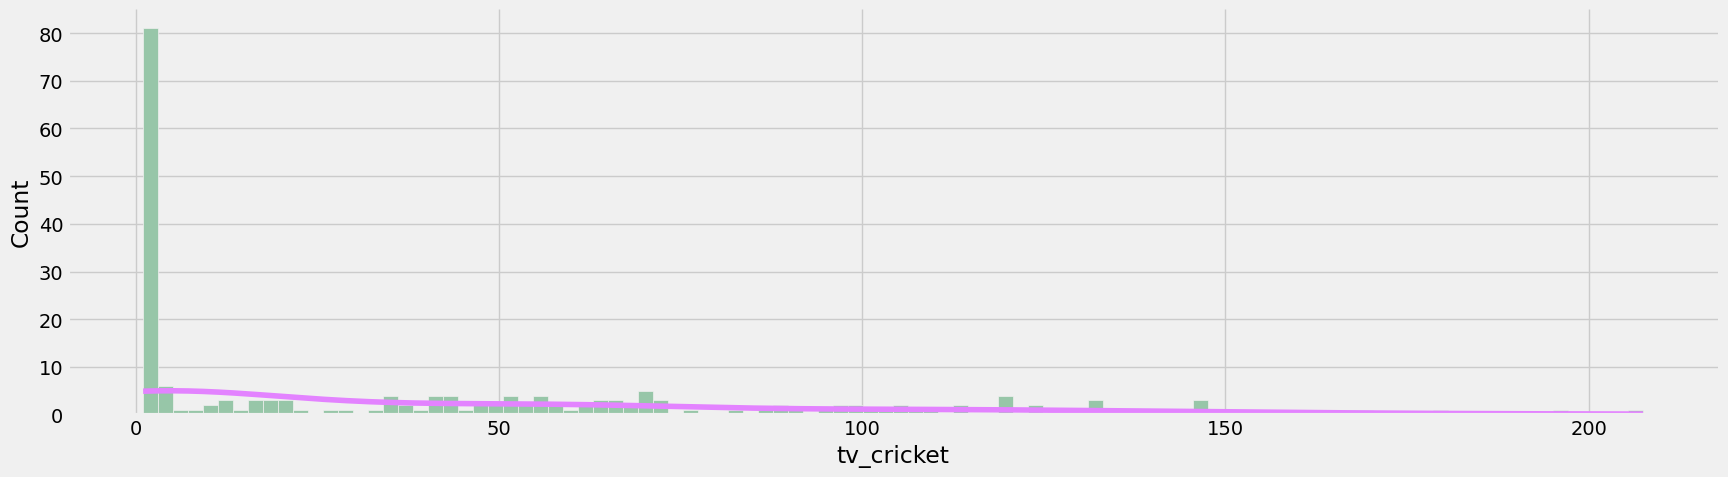

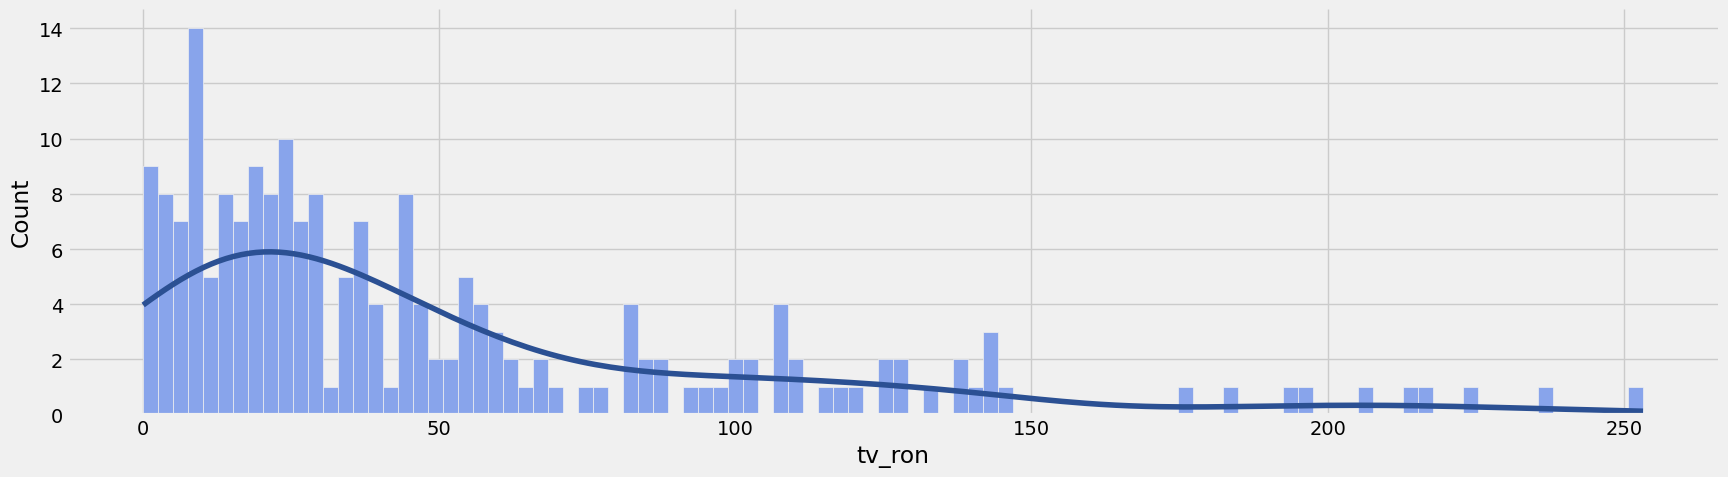

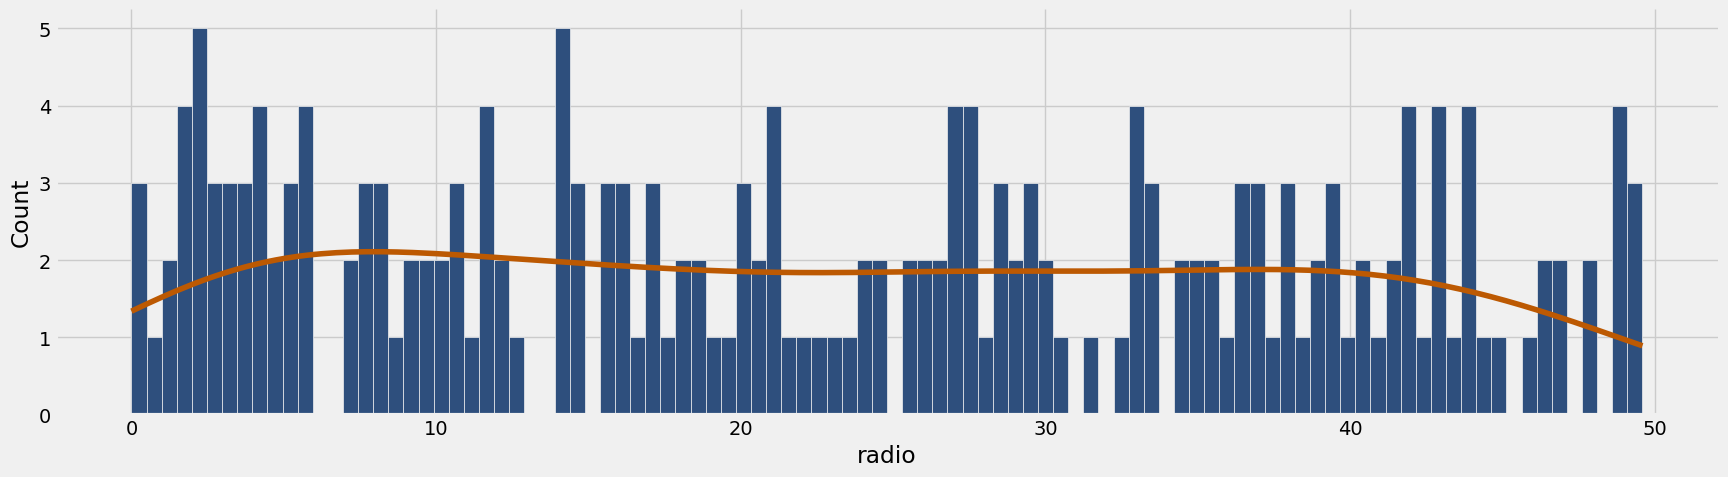

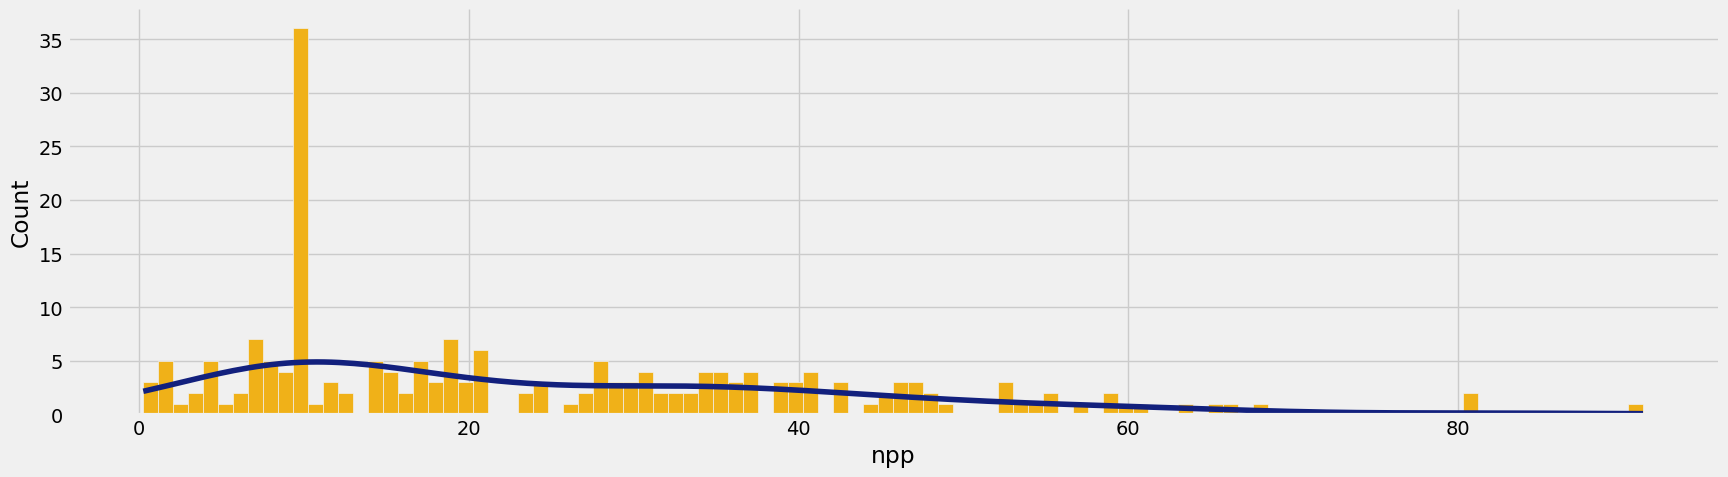

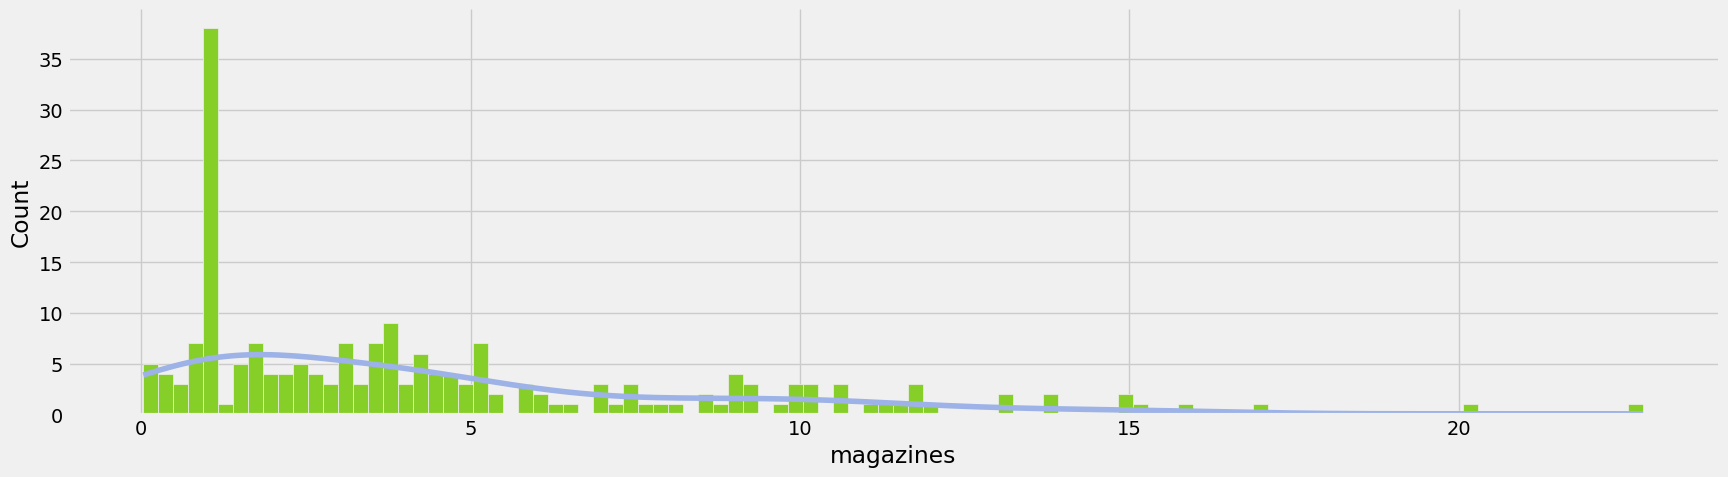

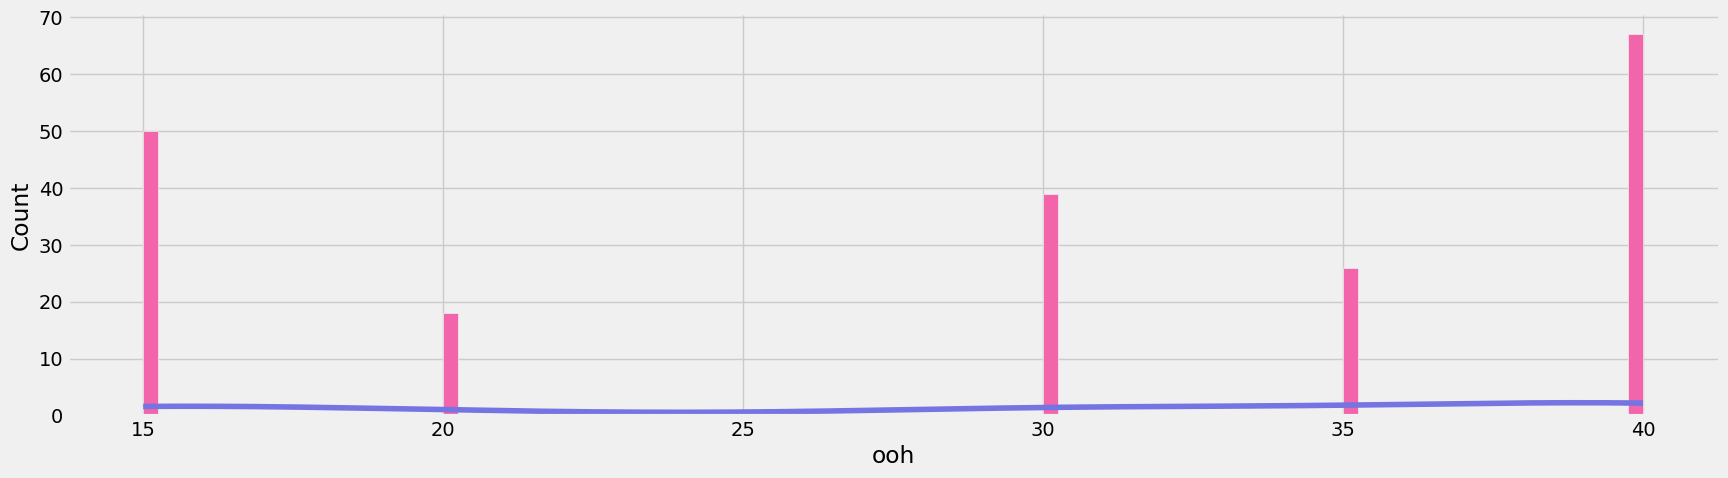

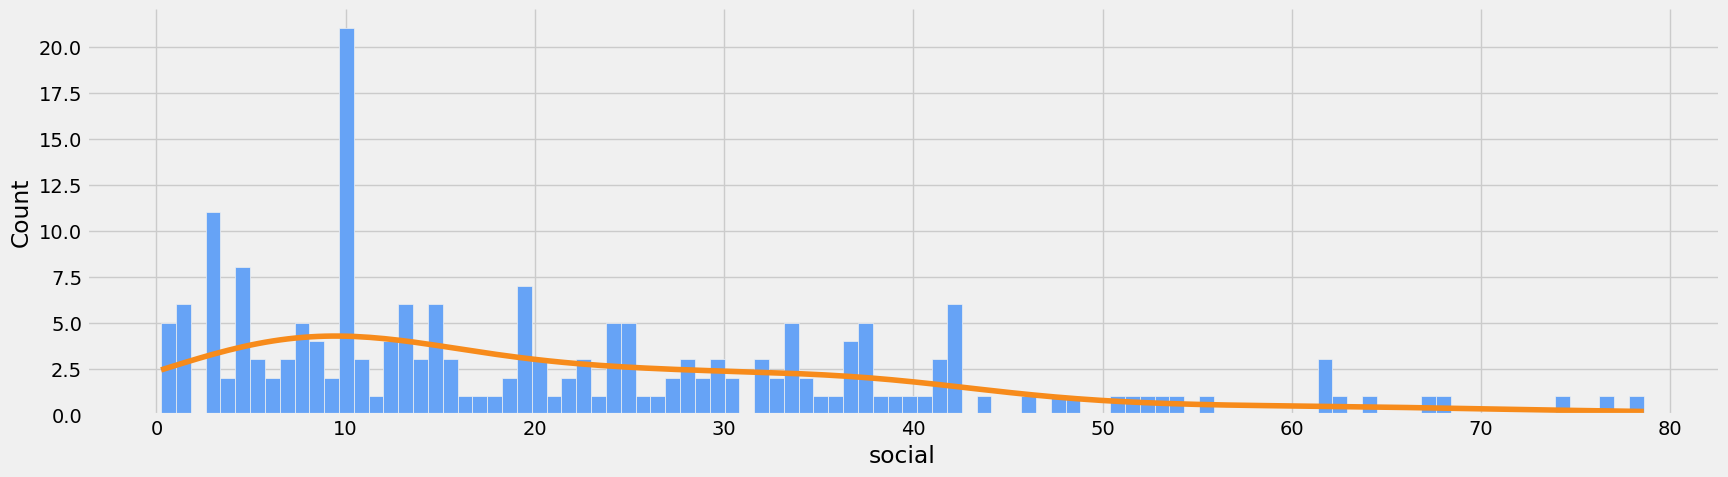

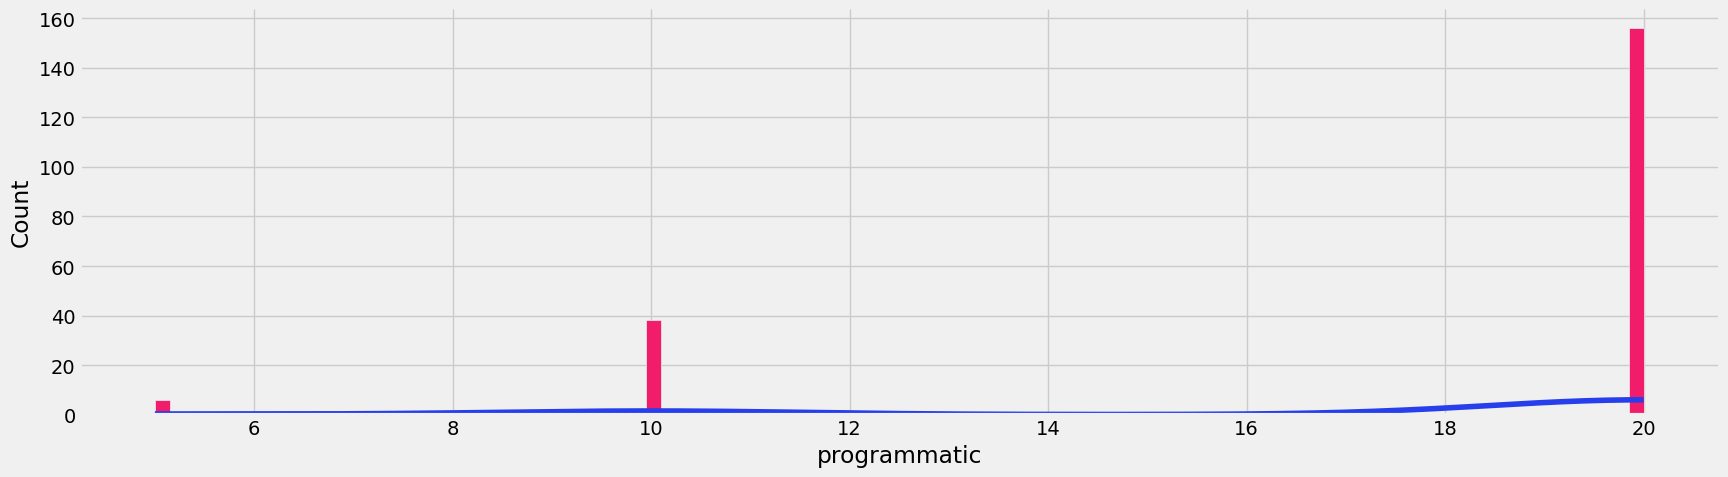

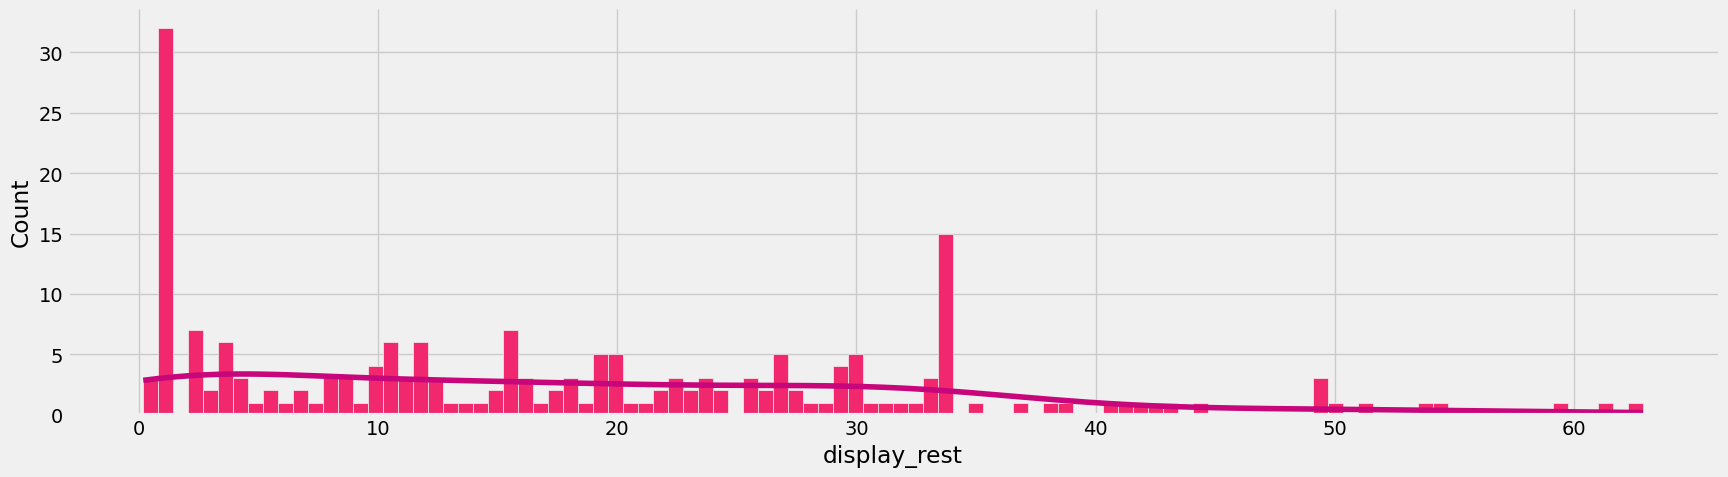

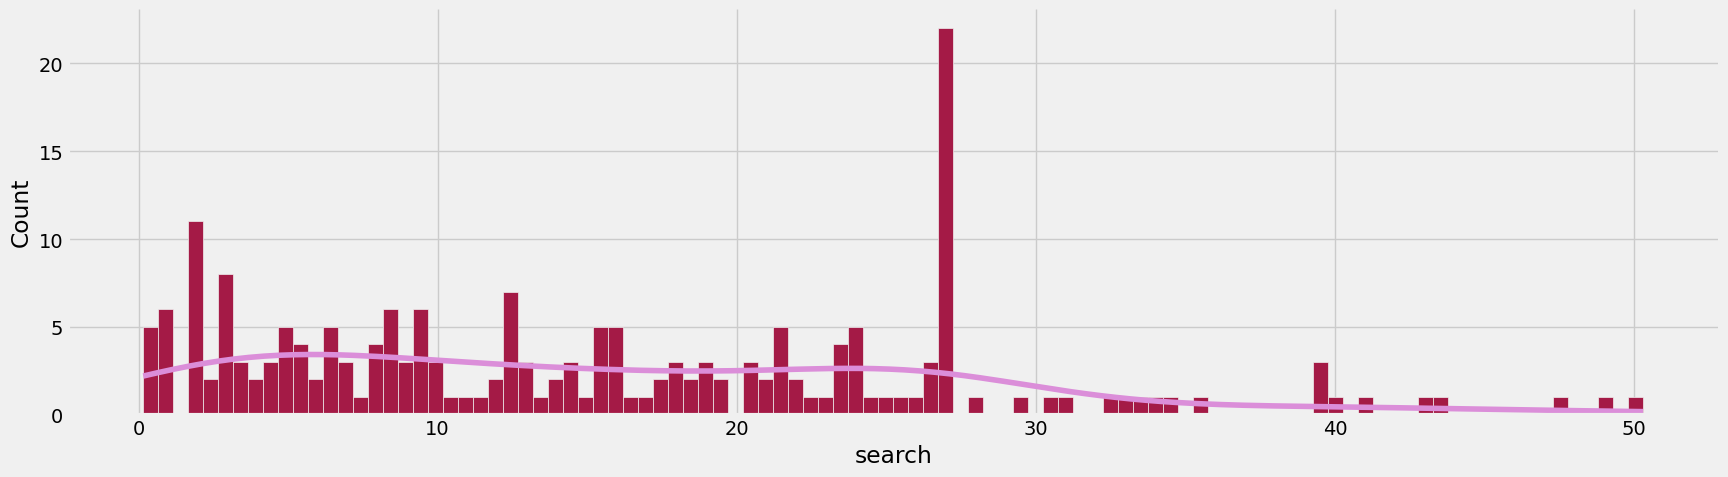

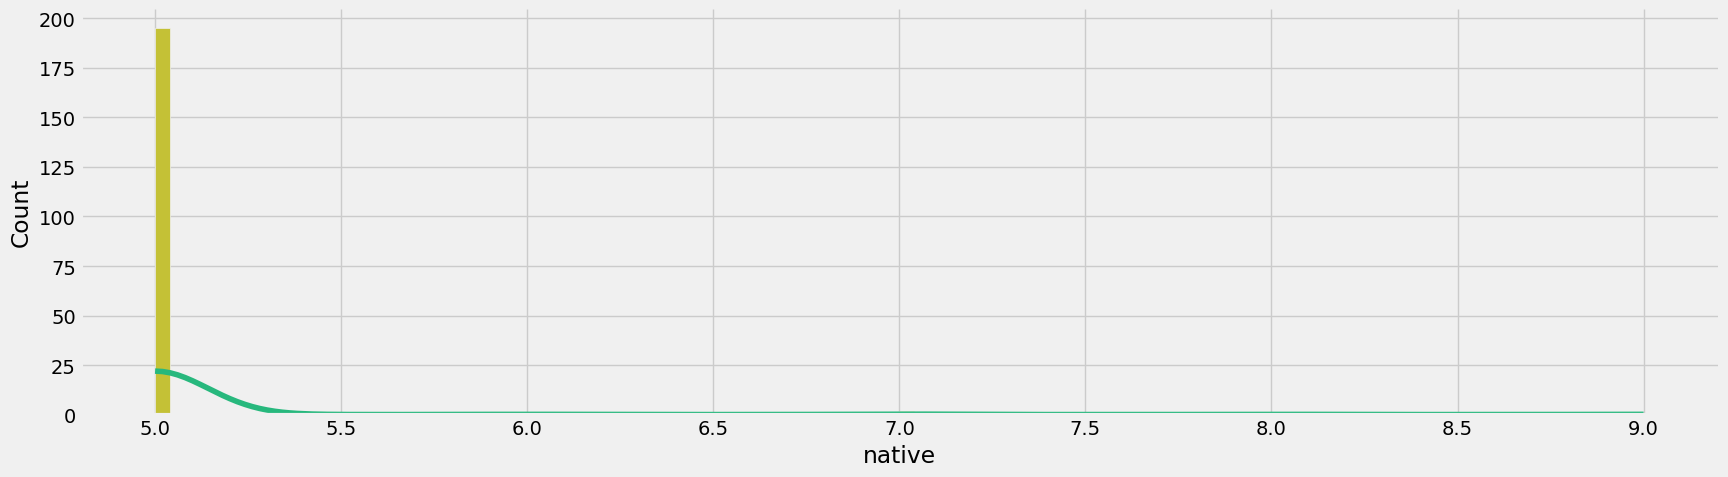

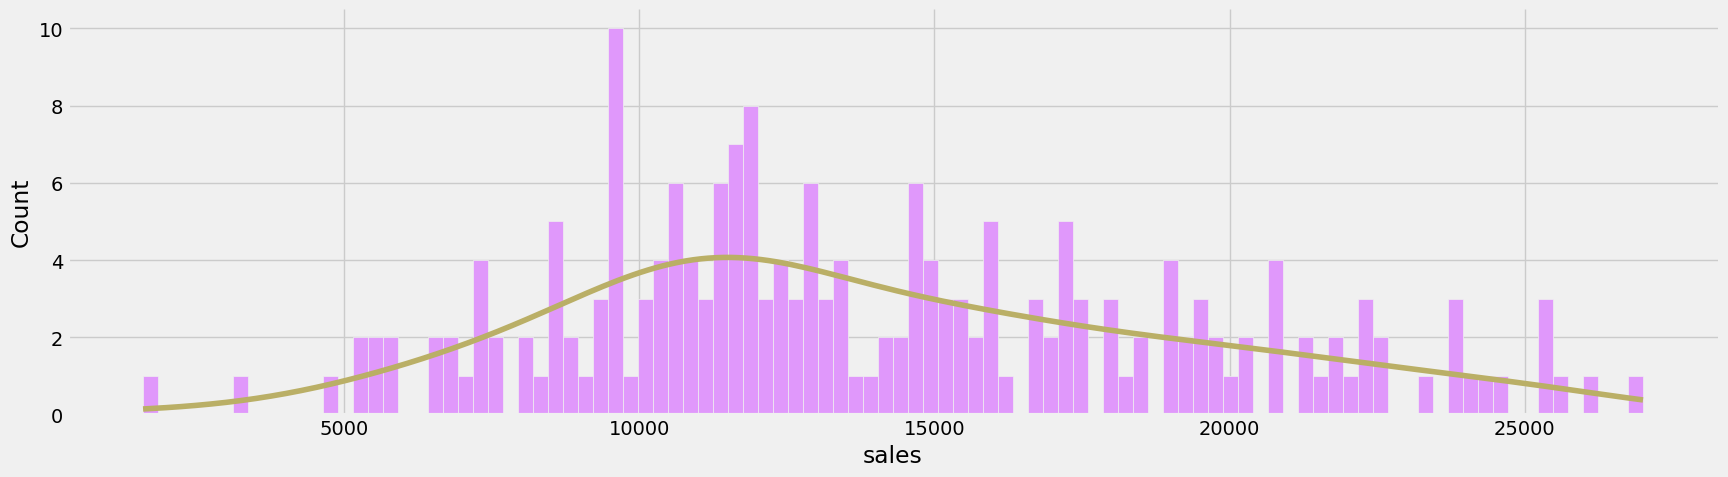

In [42]:
def random_color():
  # Generate random hex color, excluding too light colors
  while True:
    color = '#{:06x}'.format(random.randint(0, 0xFFFFFF))
    # Convert hex to RGB to check brightness
    r = int(color[1:3], 16)
    g = int(color[3:5], 16)
    b = int(color[5:7], 16)
    # Skip if color is too light (using perceived brightness formula)
    if (0.299 * r + 0.587 * g + 0.114 * b) < 200:
      return color

for column_name in df.columns:
  ax1 = sns.displot(data=df,
          x=column_name,
          kde=True,
          bins=100,
          facecolor=random_color(),
          height=5,
          aspect=3.5,
          color=random_color())

# 4. INPUT VALUE

In [43]:
# Input Data
table = df
# Input the dependent variable
dependent_var = 'sales'

# Define the independent variables
independent_vars = table.columns.drop([dependent_var,'time']).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

# 5. SCATTER PLOT FOR EACH INDEPENDENT VARIABLE

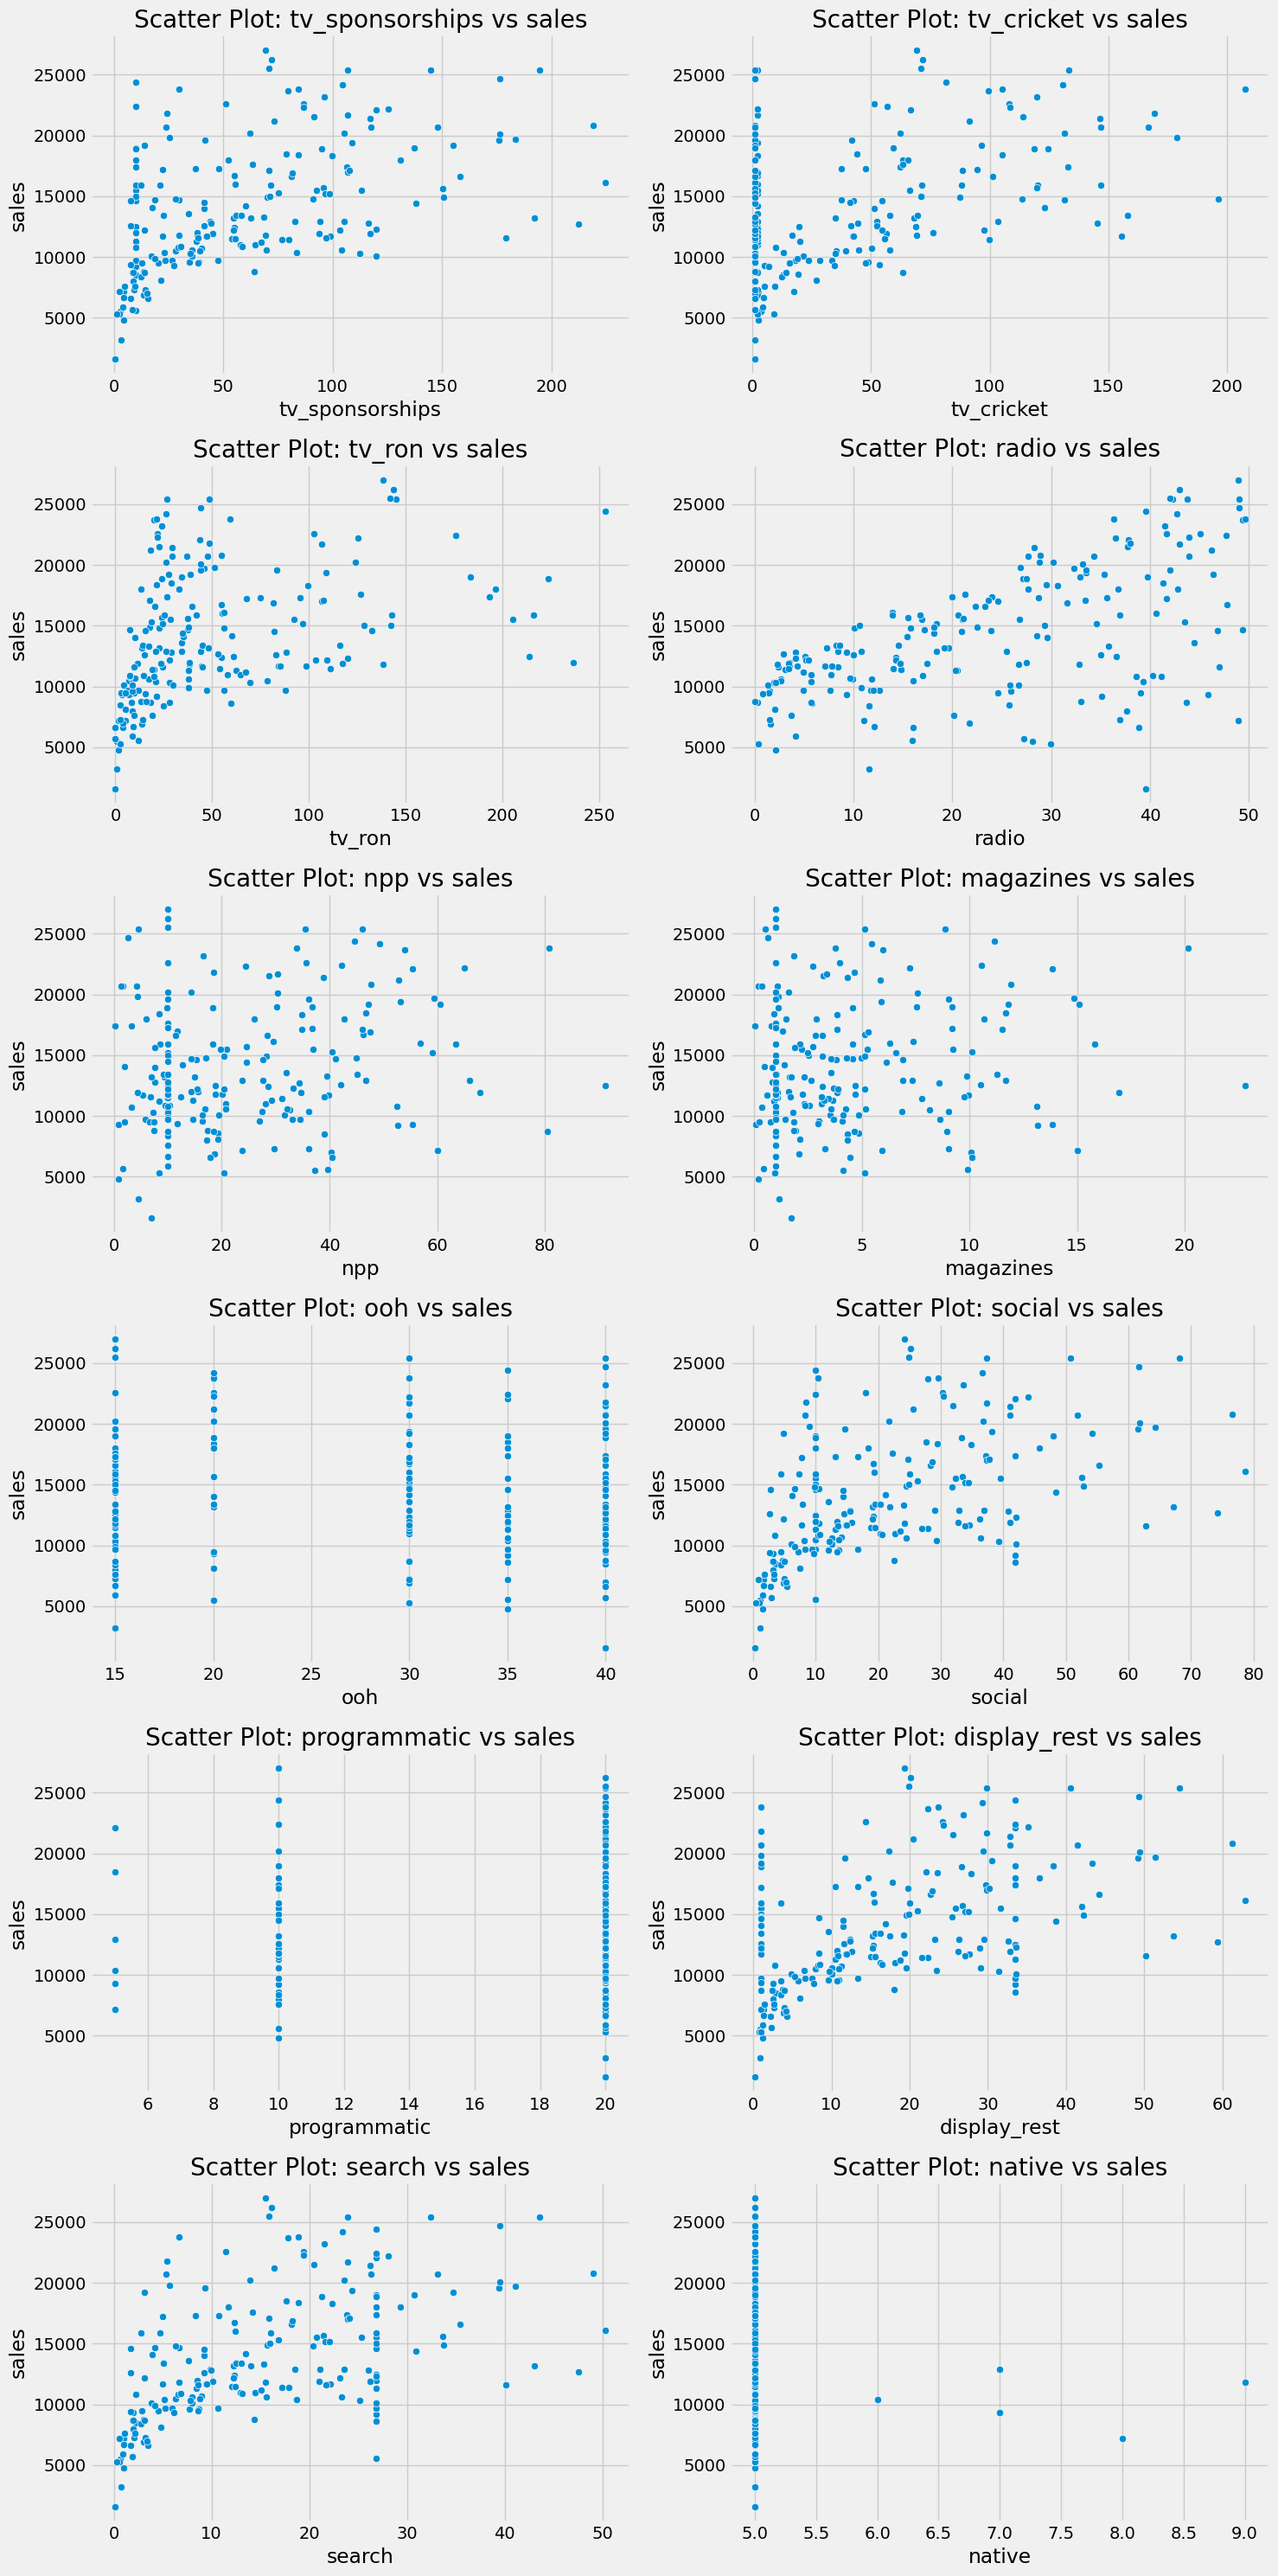

In [44]:
# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 2  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration


for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=table, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

# 6. CORRELATION COEFFICIENT

<Axes: >

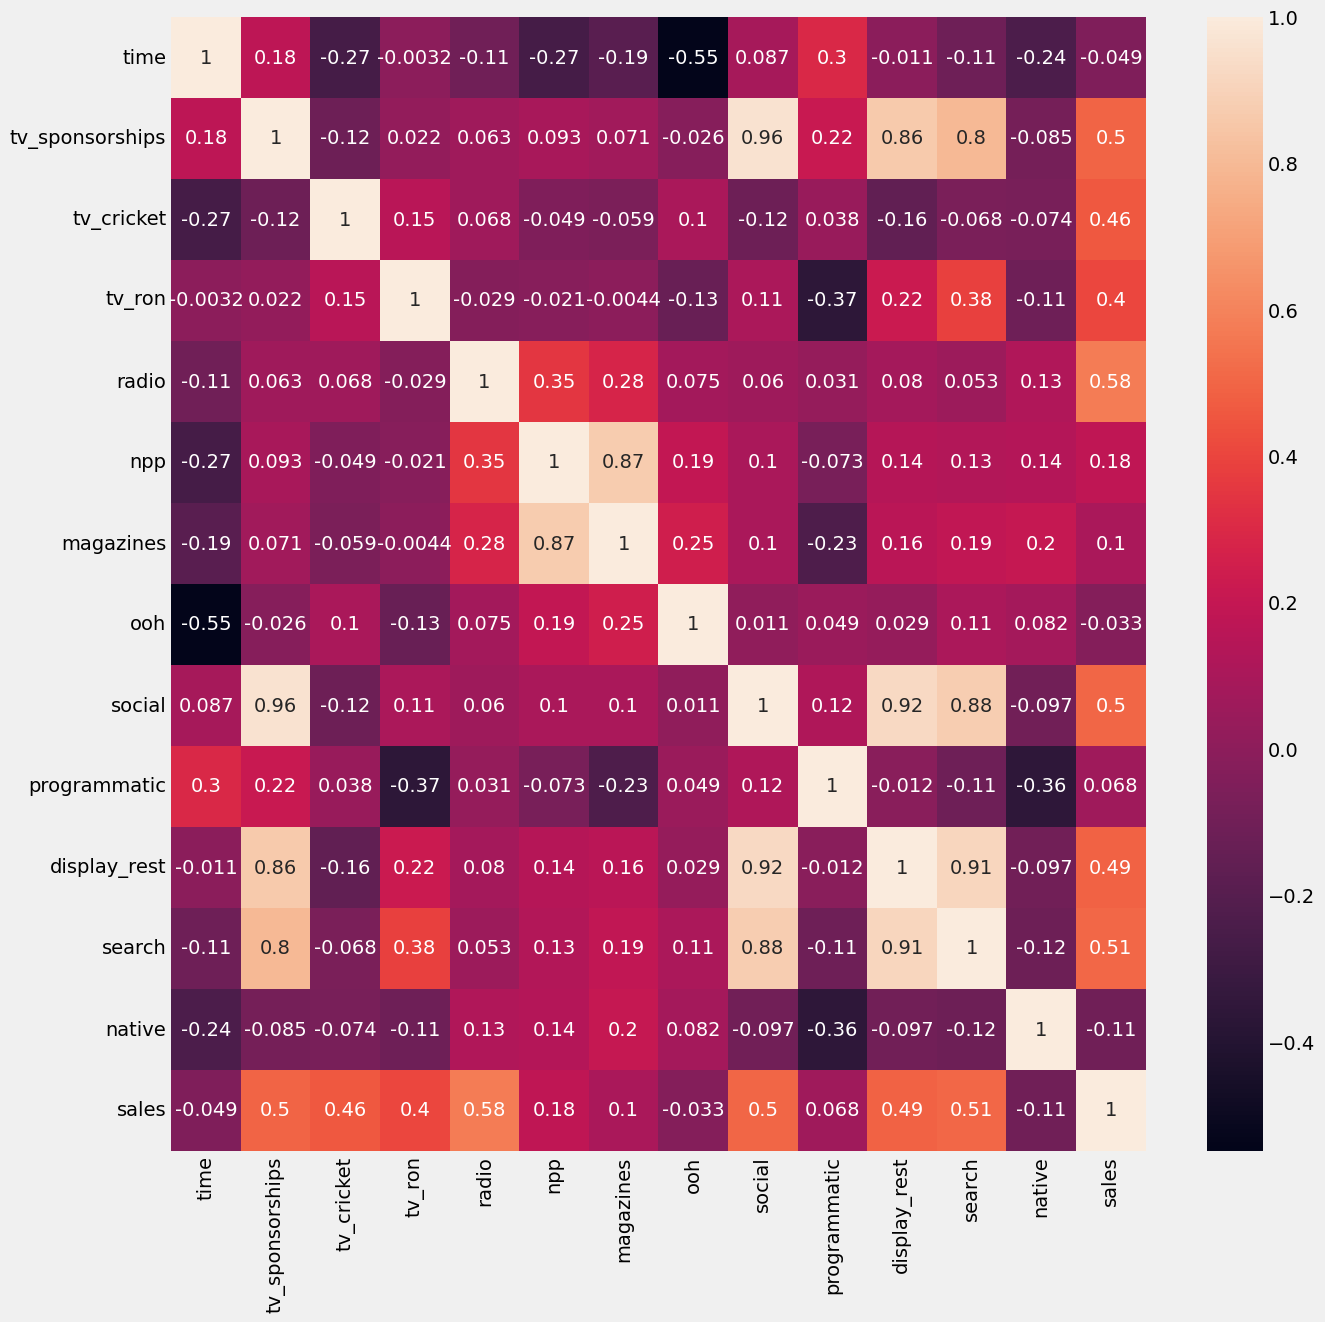

In [45]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(14, 14))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

# 6. MULTIPLE LINEAR REGRESSION

## 6.1 TRAINING MODEL

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     144.4
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.16e-87
Time:                        12:33:03   Log-Likelihood:                -1762.4
No. Observations:                 200   AIC:                             3551.
Df Residuals:                     187   BIC:                             3594.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5531.8514   2104.035     

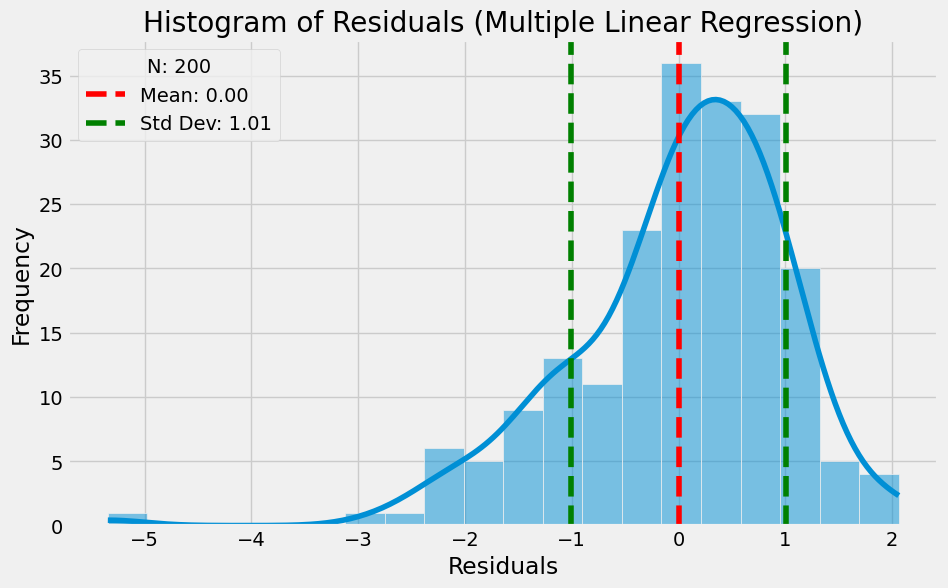

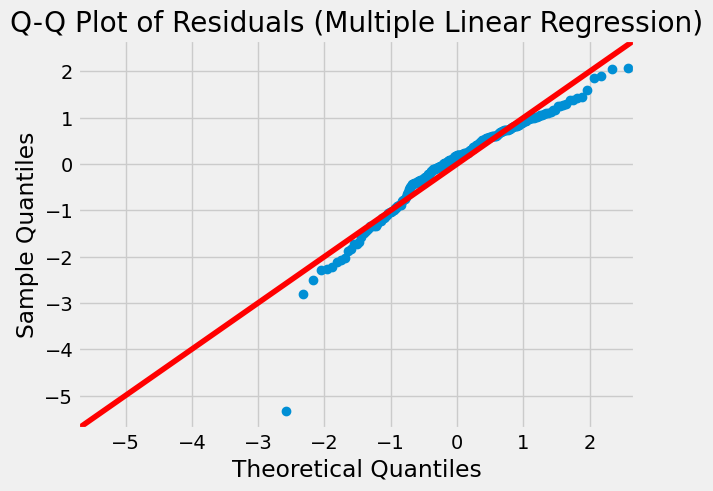

In [46]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())
print()

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})
print('Model Summary:')
print(model_summary_multiple)
print()

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_multiple)
print()

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_multiple)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
print('Kiểm định t (student):')
print(result_t_test)
print()

# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Đánh giá hiện tượng đa cộng tuyến')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_multiple.predict(table) # Prediction using model_multiple
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is relatively low, suggesting good fit.'
else:
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement.'
if rmse < 3: # example threshold, adjust as needed
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is relatively low, suggesting accurate predictions.'
else:
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement.'
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or 'Non-significant variables' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(conclusion)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.3f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.show()

## 6.2 FORECAST

In [47]:
# Predict the values using the regression model
predicted_values = model_multiple.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Get the column names of independent variables from the model
independent_vars = list(model_multiple.params.index)
independent_vars.remove('Intercept')

# Construct the column list for display, dynamically adding independent variable names
columns_to_display = independent_vars + ['predicted_values']
table[columns_to_display]
print(table)

# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({'tv_sponsorships': [250],
                         'tv_cricket': [200],
                         'tv_ron': [250],
                         'radio': [50],
                         'npp': [100],
                         'magazines': [30],
                         'ooh': [40],
                         'social': [80],
                         'programmatic': [120],
                         'display_rest': [120],
                         'search': [120],
                         'native': [10]
                         })
# Predict the dependent variable value using the regression model
predicted_sales = model_multiple.predict(new_data)
# Display the predicted value
print(f'Predicted {dependent_var} for {independent_vars}: {predicted_sales.iloc[0]}')

          time  tv_sponsorships  tv_cricket   tv_ron  radio    npp  magazines  ooh    social  programmatic  display_rest     search  native  sales  predicted_values
0   2001-01-01          119.652      66.729   43.719   37.8  55.36      13.84   35  41.87820             5      33.50256  26.802048       5  22100      19822.157998
1   2001-01-02           23.140      12.905    8.455   39.3  36.08       9.02   35   8.09900             5       6.47920   5.183360       6  10400      11192.381354
2   2001-01-03            8.944       4.988    3.268   45.9  55.44      13.86   35   3.13040             5       2.50432   2.003456       7   9300      10518.578816
3   2001-01-04           78.780      43.935   28.785   41.3  46.80      11.70   35  27.57300             5      22.05840  17.646720       5  18500      16909.946411
4   2001-01-05           94.016      52.432   34.352   10.8  46.72      11.68   35  32.90560             5      26.32448  21.059584       7  12900      11613.415432
5   2001-0

# 7. NON-LINEAR REGRESSION

## 7.1 CURVE ESTIMATION

In [48]:
# Create an empty list to store the results
results = []

# Loop through each independent variable
for independent_var in independent_vars:
    # Fit different regression models
    models = {
        "Linear": f"{dependent_var} ~ {independent_var}",
        "Logarithmic": f"{dependent_var} ~ np.log({independent_var})",
        "Quadratic": f"{dependent_var} ~ {independent_var} + I({independent_var}**2)",
        "Cubic": f"{dependent_var} ~ {independent_var} + I({independent_var}**2) + I({independent_var}**3)",
        "Power": f"np.log({dependent_var}) ~ np.log({independent_var})",  # Log-log transformation
        "Exponential": f"np.log({dependent_var}) ~ {independent_var}"  # Log transformation
    }

    for model_name, formula in models.items():
        try:
            # Fit the model
            model = smf.ols(formula, data=table).fit()

            # Extract relevant information
            rsquared = model.rsquared
            df = int(model.df_resid)  # Convert to integer
            f_statistic = model.fvalue
            p_value = model.f_pvalue
            aic = model.aic
            bic = model.bic

            # Append the results to the list
            results.append([dependent_var, independent_var, model_name, rsquared, df, f_statistic, p_value, aic, bic])

        except (ValueError, TypeError, np.linalg.LinAlgError) as e:  # Handle potential errors
            print(f"Error fitting model {model_name} for {dependent_var} ~ {independent_var}: {e}")
            # Append NaN values for the failed models
            results.append([dependent_var, independent_var, model_name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results, columns=['Dependent Var', 'Independent Vars', 'Model Name', 'rsquared', 'df', 'F Statistic', 'p_value', 'AIC', 'BIC']) # Added 'Model_Name' column
print('Curve Estimation:')
print(results_df)
print()

# Filter for significant p-values
significant_models = results_df[results_df['p_value'] <= 0.05]
# Group by 'Independent Vars' and select the row with the highest R-squared value within each group
best_models = significant_models.loc[significant_models.groupby('Independent Vars')['rsquared'].idxmax()]
print('Best Model in each Dependent Variables:')
print(best_models)

Error fitting model Logarithmic for sales ~ tv_ron: SVD did not converge
Error fitting model Power for sales ~ tv_ron: SVD did not converge
Error fitting model Logarithmic for sales ~ radio: SVD did not converge
Error fitting model Power for sales ~ radio: SVD did not converge


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

Curve Estimation:
   Dependent Var Independent Vars   Model Name  rsquared     df  F Statistic       p_value          AIC          BIC
0          sales  tv_sponsorships       Linear  0.246872  198.0    64.903515  7.251748e-14  3937.775017  3944.371651
1          sales  tv_sponsorships  Logarithmic  0.317970  198.0    92.309762  3.498464e-18  3917.942737  3924.539372
2          sales  tv_sponsorships    Quadratic  0.291307  197.0    40.488296  1.862572e-15  3927.612395  3937.507347
3          sales  tv_sponsorships        Cubic  0.292971  196.0    27.072053  1.079480e-14  3929.142451  3942.335721
4          sales  tv_sponsorships        Power  0.417072  198.0   141.664741  5.442855e-25   110.217477   116.814112
5          sales  tv_sponsorships  Exponential  0.255434  198.0    67.926788  2.299907e-14   159.165084   165.761719
6          sales       tv_cricket       Linear  0.210798  198.0    52.886477  8.034285e-12  3947.132326  3953.728961
7          sales       tv_cricket  Logarithmic

In [49]:
# Create a new table to store the transformed variables
X = pd.DataFrame()

# Iterate over the best models
for index, row in best_models.iterrows():
    dependent_var = row['Dependent Var']
    independent_var = row['Independent Vars']
    model_name = row['Model Name']

    # Apply the transformation based on the best model name
    if model_name == 'Linear':
        X[f'{independent_var}'] = table[independent_var]
    elif model_name == 'Logarithmic':
        X[f'{independent_var}_log'] = np.log(table[independent_var])
    elif model_name == 'Quadratic':
        X[f'{independent_var}_qua'] = table[independent_var] ** 2
    elif model_name == 'Cubic':
        X[f'{independent_var}_cub'] = table[independent_var] ** 3
    elif model_name == 'Power':
        X[f'{independent_var}_pow'] = np.log(table[independent_var]) # Assuming this is what you intended
    elif model_name == 'Exponential':
        X[f'{independent_var}_exp'] = np.exp(table[independent_var]) # Assuming this is what you intended
    else:
        print(f"Warning: Unknown model name '{model_name}' for {independent_var}")
        X[f'{independent_var}_cu'] = table[independent_var] # Default to original value if unknown model

y = table[dependent_var]

# Concatenate X and y into a single DataFrame
combined_df = pd.concat([X, y], axis=1)

# Display the combined DataFrame
print(combined_df.head())

   display_rest_pow        npp_cub  radio_cub  search_pow  social_pow  tv_cricket_cub    tv_ron_cub  tv_sponsorships_pow  sales
0          3.511622  169663.430656  54010.152    3.288478    3.734765   297128.184738  83562.352664             4.784588  22100
1          1.868597   46967.731712  60698.457    1.645453    2.091741     2149.186118    604.422796             3.141563  10400
2          0.918017  170400.029184  96702.579    0.694874    1.141161      124.102158     34.901665             2.190983   9300
3          3.093693  102503.232000  70444.997    2.870550    3.316837    84807.037425  23850.566637             4.366659  18500
4          3.270499  101978.472448   1259.712    3.047356    3.493643   144141.577966  40537.417822             4.543465  12900


## 7.2 STEPWISE SELECTION

In [50]:
# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    if X.shape[1] > 1:  # Check if there are more than 1 columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    else:
        vif["VIF"] = [np.nan]  # Assign NaN if only one column is present
    return vif

# Function to perform stepwise regression
def stepwise_selection(X, y, threshold_in=0.005, threshold_out=0.005):
    initial_features = X.columns.tolist()
    best_features = []
    model_details = []  # List to store details of each regression model

    while True:
        changed = False

        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

            # Save model details
            model_details.append({
                'Features': best_features + [new_column],
                'AIC': model.aic,
                'BIC': model.bic,
                'R-squared': model.rsquared,
                'Adjusted R-squared': model.rsquared_adj
            })

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_features.append(new_pval.idxmin())
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)

        if not changed:
            break

    return best_features, model_details

# Perform stepwise regression
best_features, model_details = stepwise_selection(X, y)

# Print details of all regression models
print("All Models Details:")
for idx, details in enumerate(model_details, 1):
    print(f"Model {idx}:")
    print(f"Features: {details['Features']}")
    print(f"R-squared: {details['R-squared']:.4f}, Adjusted R-squared: {details['Adjusted R-squared']:.4f}") #AIC: {details['AIC']:.4f}, BIC: {details['BIC']:.4f},

    # Calculate VIF for the current model
    current_model_X = X[details['Features']]
    current_vif = calculate_vif(current_model_X)
    print(f"VIF for Model {idx}:")
    print(current_vif)
    print("-" * 40)
print()

# Filter for significant p-values and VIF < 10
filtered_models = []
for idx, details in enumerate(model_details):
    current_model_X = X[details["Features"]]
    current_vif = calculate_vif(current_model_X)

    # Check for VIF values less than 10 (excluding intercept if present)
    valid_vif = True
    if 'const' in current_vif['Variable'].values:
      current_vif = current_vif[current_vif['Variable'] != 'const']

    #Check if all VIF values are less than 10
    if len(current_vif) > 0 and current_vif['VIF'].max() >= 10:
        valid_vif = False

    if valid_vif:
        filtered_models.append(details)

# Find best model within filtered ones
best_model_filtered = None
best_r_squared = -1

for model in filtered_models:
    if model['R-squared'] > best_r_squared:
        best_r_squared = model['R-squared']
        best_model_filtered = model

print("Best Model after filtering by VIF < 10:")
if best_model_filtered:
    # print(best_model_filtered)
    #Fit the best model
    best_model = sm.OLS(y, sm.add_constant(X[best_model_filtered['Features']])).fit()
    print(best_model.summary())
    print()
    print("VIF for best model:")
    print(calculate_vif(X[best_model_filtered['Features']]))
else:
    print("No model found within VIF < 10")

All Models Details:
Model 1:
Features: ['display_rest_pow']
R-squared: 0.2047, Adjusted R-squared: 0.2007
VIF for Model 1:
           Variable  VIF
0  display_rest_pow  NaN
----------------------------------------
Model 2:
Features: ['tv_ron_cub']
R-squared: 0.0562, Adjusted R-squared: 0.0514
VIF for Model 2:
     Variable  VIF
0  tv_ron_cub  NaN
----------------------------------------
Model 3:
Features: ['npp_cub']
R-squared: 0.0174, Adjusted R-squared: 0.0125
VIF for Model 3:
  Variable  VIF
0  npp_cub  NaN
----------------------------------------
Model 4:
Features: ['tv_cricket_cub']
R-squared: 0.1193, Adjusted R-squared: 0.1149
VIF for Model 4:
         Variable  VIF
0  tv_cricket_cub  NaN
----------------------------------------
Model 5:
Features: ['tv_sponsorships_pow']
R-squared: 0.3180, Adjusted R-squared: 0.3145
VIF for Model 5:
              Variable  VIF
0  tv_sponsorships_pow  NaN
----------------------------------------
Model 6:
Features: ['radio_cub']
R-squared: 0.2867, 

## 7.3 TABLE DATA

In [51]:
independent_vars = best_model_filtered['Features']
dependent_var = y.name
print(dependent_var)
table_nonlinear = combined_df[[dependent_var] + independent_vars] # Use combined_df
print(table_nonlinear.head())

sales
   sales  radio_cub  tv_cricket_cub    tv_ron_cub  tv_sponsorships_pow        npp_cub
0  22100  54010.152   297128.184738  83562.352664             4.784588  169663.430656
1  10400  60698.457     2149.186118    604.422796             3.141563   46967.731712
2   9300  96702.579      124.102158     34.901665             2.190983  170400.029184
3  18500  70444.997    84807.037425  23850.566637             4.366659  102503.232000
4  12900   1259.712   144141.577966  40537.417822             4.543465  101978.472448


## 7.4 TRAINING MODEL

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     157.5
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           2.74e-66
Time:                        12:33:05   Log-Likelihood:                -1833.1
No. Observations:                 200   AIC:                             3678.
Df Residuals:                     194   BIC:                             3698.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             524.4253    

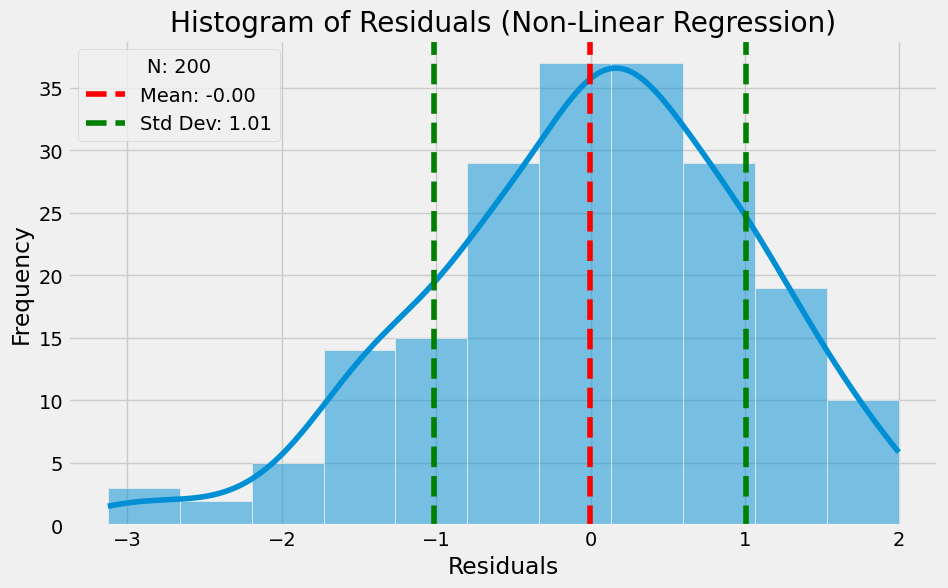

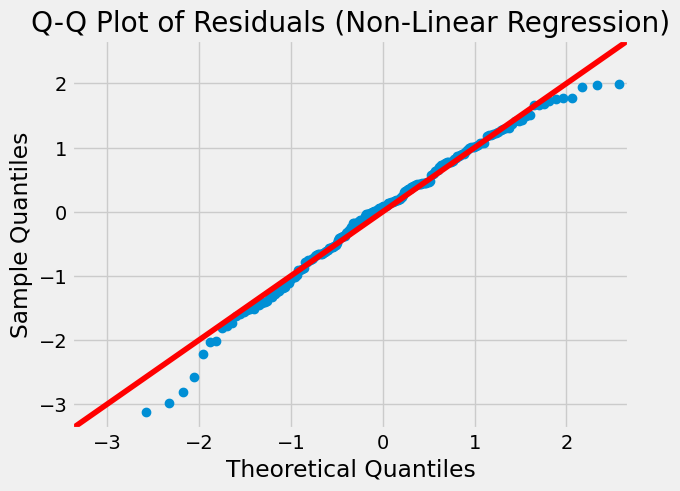

In [52]:
# Tạo mô hình hồi quy phi tuyến tính sử dụng công thức
# Create the formula for the none-linear regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the non-linear regression model using the formula
model_nonlinear_optimize = smf.ols(formula, data=table_nonlinear).fit()
print(model_nonlinear_optimize.summary())
print()

# Kiểm định Durbin-Watson
residuals_nonelinear = model_nonlinear_optimize.resid
durbin_watson_nonlinear = sm.stats.stattools.durbin_watson(residuals_nonelinear)

# Redesign the model_summary table
model_summary_nonlinear = pd.DataFrame({
  'Date': [model_nonlinear_optimize.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_nonlinear_optimize.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_nonlinear_optimize.rsquared],
  'Adj. R-squared': [model_nonlinear_optimize.rsquared_adj],
  'Durbin Watson': [durbin_watson_nonlinear]
})
print('Model Summary:')
print(model_summary_nonlinear)
print()

# Bảng ANOVA
anova_table_nonlinear = sm.stats.anova_lm(model_nonlinear_optimize, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table_nonlinear[dependent_var] - table_nonlinear[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_nonlinear['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_nonlinear_optimize.summary().tables[0][6][1].data
df_residual = model_nonlinear_optimize.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_nonlinear_optimize.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_nonlinear_optimize.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_nonlinear = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_nonlinear['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_nonlinear)
print()

# Bảng Coefficients
coefficients_nonlinear = model_nonlinear_optimize.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_nonlinear_optimize.params * (table_nonlinear[independent_vars].std() / table_nonlinear[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_nonlinear['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
if len(independent_vars) == 1:
  vif_data == None
else:
  vif_data = pd.DataFrame()
  vif_data["Variable"] = independent_vars
  vif_data["VIF"] = [variance_inflation_factor(table_nonlinear[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_nonlinear dataframe
coefficients_nonlinear = coefficients_nonlinear.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
if len(independent_vars) == 1:
  coefficients_nonlinear = coefficients_nonlinear[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]']]
else:
  coefficients_nonlinear = coefficients_nonlinear[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_nonlinear)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_nonlinear_optimize.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_nonlinear.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_nonlinear < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_nonlinear['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_nonlinear[(coefficients_nonlinear['P>|t|'] < alpha) & (coefficients_nonlinear['Variable'] != 'Intercept')]
non_significant_vars = coefficients_nonlinear[(coefficients_nonlinear['P>|t|'] >= alpha) & (coefficients_nonlinear['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
if len(independent_vars) == 1:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
else:
  multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
  if not multicollinearity_vars.empty:
    multicollinearity_result = "There is a possibility of multicollinearity"
  else:
    multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Kiểm định t (student)')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_nonlinear_optimize.predict(table_nonlinear) # Prediction using model_nonlinear
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is relatively low, suggesting good fit.'
else:
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement.'
if rmse < 3: # example threshold, adjust as needed
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is relatively low, suggesting accurate predictions.'
else:
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement.'
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(multicollinearity_result)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_nonlinear:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')
print('Hypothsis Test:')
print(hypothesis_test)
print()

# Viết phương trình hồi quy
intercept = coefficients_nonlinear.loc[coefficients_nonlinear['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_nonlinear.loc[coefficients_nonlinear['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.6f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.6f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.6f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_nonelinear = model_nonlinear_optimize.get_influence().resid_studentized_internal
mean_residuals_nonelinear = standardized_residuals_nonelinear.mean()
std_dev_residuals_nonelinear = standardized_residuals_nonelinear.std()
N_residuals_nonelinear = len(standardized_residuals_nonelinear)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_nonelinear, kde=True)
plt.title('Histogram of Residuals (Non-Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_nonelinear, color='r', linestyle='--', label=f'Mean: {mean_residuals_nonelinear:.2f}')
plt.axvline(mean_residuals_nonelinear + std_dev_residuals_nonelinear, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_nonelinear:.2f}')
plt.axvline(mean_residuals_nonelinear - std_dev_residuals_nonelinear, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_nonelinear}')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_nonelinear, line='45')
plt.title('Q-Q Plot of Residuals (Non-Linear Regression)')
plt.show()
print()

## 7.5 FORECAST

In [53]:
# Predict the values using the regression model
predicted_values = model_nonlinear_optimize.predict(table_nonlinear)

# Add the predicted values to the dataframe
table_nonlinear['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
print(table_nonlinear)

     sales   radio_cub  tv_cricket_cub    tv_ron_cub  tv_sponsorships_pow        npp_cub  predicted_values
0    22100   54010.152    2.971282e+05  8.356235e+04             4.784588  169663.430656      18249.986137
1    10400   60698.457    2.149186e+03  6.044228e+02             3.141563   46967.731712      13934.394311
2     9300   96702.579    1.241022e+02  3.490166e+01             2.190983  170400.029184      13932.244828
3    18500   70444.997    8.480704e+04  2.385057e+04             4.366659  102503.232000      18144.603858
4    12900    1259.712    1.441416e+05  4.053742e+04             4.543465  101978.472448      13299.903037
5     7200  116930.169    1.606023e+01  4.516672e+00             1.509397  216000.000000      13559.684455
6    11800   35287.552    4.636578e+03  1.303960e+03             3.397858    6644.672000      12716.207882
7    13200    7529.536    4.235526e+04  1.191171e+04             4.135231     799.178752      12651.746878
8     4800       9.261    1.551277e+0

<ipython-input-53-22dd778a36d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_nonlinear['predicted_values'] = predicted_values


In [54]:
# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
radio_value = 50
tv_cricket_value = 200
tv_ron_value = 250
tv_sponsorships_value = 250
npp_value = 100

new_data = pd.DataFrame({
    'radio_cub': [(radio_value)** 3],
    'tv_cricket_cub': [(tv_cricket_value)** 3],
    'tv_ron_cub': [(tv_ron_value)** 3],
    'tv_sponsorships_pow': [np.log(tv_sponsorships_value)],
    'npp_cub': [(npp_value)** 3],

})
# Predict the dependent variable value using the regression model
predicted_values = model_nonlinear_optimize.predict(new_data)

# Display the predicted value
print(f'Predicted {dependent_var}: {predicted_values.iloc[0]}')

Predicted sales: 47885.75399872907
